# Data encoding

In this page, we will introduce the problem of data encoding for quantum machine learning, then describe and implement various data encoding methods. 

## Introduction

Data representation is crucial for the success of machine learning models. For classical machine learning, the problem is how to represent the data numerically, so that it can be best processed by a classical machine learning algorithm. 

For quantum machine learning, this question is similar, but more fundamental: how to represent and efficiently input the data into a quantum system, so that it can be processed by a quantum machine learning algorithm. This is usually referred to as data *encoding*, but is also called data *embedding* or *loading*.

This process is a critical part of quantum machine learning algorithms and directly affects their computational power. 

## Methods

Let's consider a classical dataset $\mathscr{X}$ consisting of $M$ samples, each with $N$ [features](gloss:features):

$$\class{script-x}{\mathscr{X}} = \class{brace}{\{}x^{(1)},\class{ellipsis}{\dots},\cssId{_x-lil-m}{x^{(m)}},\dots,x^{(M)}\class{brace}{\}}$$

where $x^{(m)}$ is an $N$ dimensional vector for $m = 1, ..., M$. To represent this dataset in a qubit system, we can use various embedding techniques, some of which are briefly explained and implemented below, as per References [1](#References) and  [2](#References).

### Basis encoding

Basis encoding associates a classical $N$-bit string with a [computational basis state](gloss:computational-basis-state) of a $N$-qubit system. For example, if $x = 5$, this can be represented as a $4$-bit string as $0101$, and by a $4$-qubit system as the quantum state $|0101\rangle$. More generally, for an $N$-bit string: $x = (b_1, b_2, ... , b_N)$, the corresponding $N$-qubit state is $\cssId{ket-x}{| x \rangle} = | b_1, b_2, ... , b_N \rangle$ with $b_n \class{in}{\in} \{0,1\}$ for $n = 1 , \dots , N$.

For the classical dataset $\mathscr{X}$ described above, to use basis encoding, each data point must be a $N$-bit string: $x^{(m)} = (b_1, b_2, ... , b_N)$, which then can be mapped directly to the quantum state $|x^{m}\rangle = |b_1, b_2, ... , b_N \rangle$ with $b_n \in \{0, 1 \} $ for $n = 1, ...,  N$ and $m = 1, ..., M$. We can represent the entire dataset as superpositions of computational basis states:

$$\cssId{_ket-dataset}{| \mathscr{X} \rangle} = \frac{1}{\sqrt{\cssId{_m}{M}}}\cssId{_sum-m}{\sum_{m=1}^{M}|x^{m} \rangle} $$

<!-- ::: q-block -->

### Basis encoding

    q-statevector-binary-encoding
      p Add/remove bit strings to/from our input dataset on the left to see how basis encoding encodes this in the state vector on the right. 

<!-- ::: -->

In Qiskit, once we calculate what state will encode our dataset, we can use the `initialize` function to prepare it. For example, the dataset $\mathscr{X} = \{x^{(1)}=101, x^{(2)}=111\}$ is encoded as the state $|\mathscr{X}\rangle= \frac{1}{\sqrt{2}}(|101\rangle+|111\rangle)$:

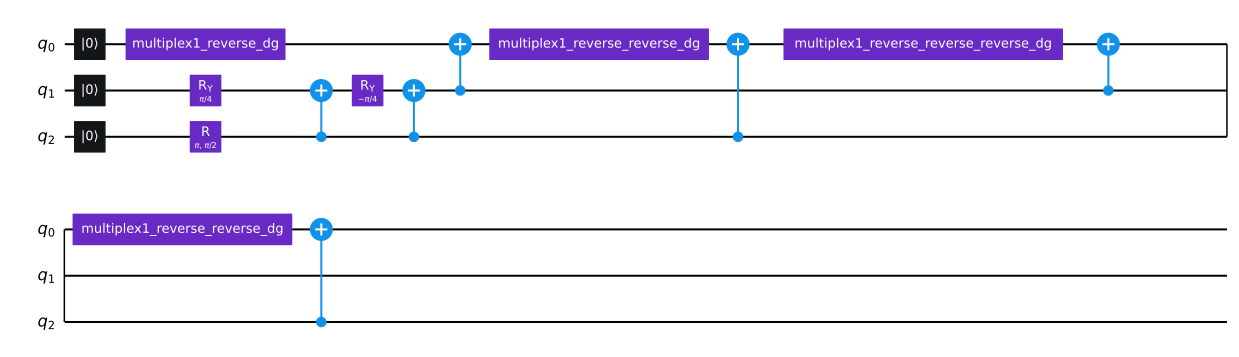

In [1]:
import math
from qiskit import QuantumCircuit

desired_state = [
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(2),
    0,
    1 / math.sqrt(2)]

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0,1,2])
qc.decompose().decompose().decompose().decompose().decompose().draw()

This example illustrates a couple of disadvantages of basis encoding. While it is simple to understand, the state vectors can become quite sparse, and schemes to implement it are usually not efficient. 

### Amplitude encoding

Amplitude encoding encodes data into the amplitudes of a quantum state. It represents a normalised classical $N$-dimensional data point, $x$, as the amplitudes of a $n$-qubit quantum state, $|\psi_x\rangle$:

$$|\psi_x\rangle = \sum_{i=1}^N x_i |i\rangle$$

where $N = 2^n$, $x_i$ is the $i^{th}$ element of $x$ and $|i\rangle$ is the $i^{th}$ computational basis state. 

To encode the classical dataset $\mathscr{X}$ described above, we concatenate all $M$ $N$-dimensional data points into one amplitude vector, of length $N \times M$:

$$\alpha=\cssId{_a-norm}{A_{\text{norm}}}(x_{1}^{(1)},...,x_{N}^{(1)},...,x_{1}^{(m)},...,x_{N}^{(m)},...,x_{1}^{(M)},...,x_{N}^{(M)})$$

where $A_{\text{norm}}$ is a normalisation constant, such that $|\alpha|^2 = 1$. The dataset $\mathscr{X}$ can now be represented in the computational basis as:

$$|\mathscr{X}\rangle = \sum_{i=1}^N \alpha_i |i\rangle$$

where $\alpha_i$ are elements of the amplitude vector and $|i\rangle$ are the computational basis states. The number of amplitudes to be encoded is $N \times M$.  As a system of $n$ qubits provides $2^n$ amplitudes, amplitude embedding requires $n \ge \mathrm{log}_2(NM)$ qubits.

<!-- ::: q-block -->

### Amplitude encoding

    q-statevector-amplitude-encoding
      p Change the values of the data points on the left, and see how amplitude encoding encodes these as a state vector on the right.

<!-- ::: -->

As an example, let's encode the dataset $\mathscr{X}= \{x^{(1)}=(1.5,0), x^{(2)}=(-2,3)\}$ using amplitude encoding. Concatenating both data points and normalizing the resulting vector, we get:

$$\alpha = \frac{1}{\sqrt{15.25}}(1.5,0,-2,3)$$

and the resulting 2-qubit quantum state would be:

$$|\mathscr{X}\rangle = \frac{1}{\sqrt{15.25}}(1.5|00\rangle-2|10\rangle+3|11\rangle)$$

In the example above, the total number of elements of the amplitude vector, $N \times M$, is a power of 2. When $N \times M$ is not a power of 2, we can simply choose a value for $n$ such that $2^n\geq MN$ and pad the amplitude vector with uninformative constants.

Like in basis encoding, once we calculate what state will encode our dataset, in Qiskit we can use the `initialize` function to prepare it:

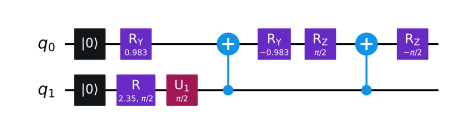

In [2]:
desired_state = [
    1 / math.sqrt(15.25) * 1.5,
    0,
    1 / math.sqrt(15.25) * -2,
    1 / math.sqrt(15.25) * 3]

qc = QuantumCircuit(2)
qc.initialize(desired_state, [0,1])

qc.decompose().decompose().decompose().decompose().decompose().draw()

The advantage of amplitude encoding is that it only requires $\mathrm{log}_2(NM)$ qubits to encode. However, subsequent algorithms must operate on the amplitudes of a quantum state, and methods to prepare and measure the quantum states tend not to be efficient. 

### Angle encoding

Angle encoding encodes $N$ features into the rotation angles of $n$ qubits, where $N \le n$. For example, the data point $x = (x_1,...,x_N)$ can be encoded as:

$$\cssId{_}{|x\rangle} = \class{_big-o-times-n}{\bigotimes^N_{i=1}} \cos(x_i)|0\rangle + \sin(x_i)|1\rangle$$

This is different from the previous two encoding methods, as it only encodes one data point at a time, rather than a whole dataset. It does however, only use $N$ qubits and a constant depth quantum circuit, making it amenable to current quantum hardware. 

We can specify angle encoding as a [unitary](gloss:unitary):

$$ S_{x_j} = \class{_big-o-times-n}{\bigotimes_{i=1}^N} U(x_j^{(i)}) $$

where:

$$
U(x_j^{(i)}) = \begin{bmatrix} \cos(x_j^{(i)}) & -\sin(x_j^{(i)}) \\ \sin(x_j^{(i)}) & \cos(x_j^{(i)}) \\ \end{bmatrix}
$$

Remembering that a single-qubit rotation around the $Y$-axis is:

$$RY(\theta) = \exp(-i \frac{\theta}{2} Y) = \begin{pmatrix} \cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\ \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{pmatrix} $$            
            
We note that $U(x_j^{(i)}) = RY(2x_j^{(i)})$, and as an example, encode the data point $x = (0, \pi/4, \pi/2)$ using qiskit:

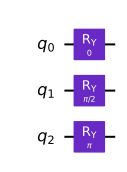

In [3]:
qc = QuantumCircuit(3)
qc.ry(0, 0)
qc.ry(2*math.pi/4, 1)
qc.ry(2*math.pi/2, 2)
qc.draw()

Dense angle encoding is a slight generalization of angle encoding, that encodes two features per qubit using the relative phase, where the data point $x = (x_1,...,x_N)$ can be encoded as:

$$|x\rangle = \class{_big-o-times-n2}{\bigotimes_{i=1}^{N/2}} \cos(x_{2i-1})|0\rangle + e^{i x_{2i}}\sin(x_{2i-1})|1\rangle$$

Although the angle and dense angle encoding use sinusoids and exponentials, there is nothing special about these functions. We can easily abstract these to a general class of qubit encodings that use arbitrary functions, or define the encodings as arbitrary unitaries, implemented as parameterized quantum circuits.

### Arbitrary encoding

Arbitrary encoding encodes $N$ features as rotations on $N$ parameterized gates on $n$ qubits, where $n \leq N$. Like angle encoding, it only encodes one data point at a time, rather than a whole dataset. It also uses a constant depth quantum circuit and $n \leq N$ qubits, meaning it can be run on current quantum hardware. 

For example, to use the Qiskit [`EfficientSU2`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html) circuit to encode 12 features, would only use 3 qubits:

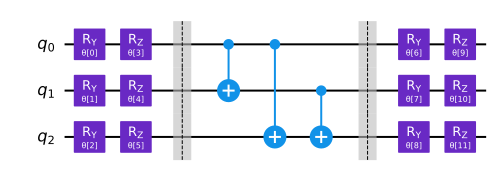

In [4]:
from qiskit.circuit.library import EfficientSU2
circuit = EfficientSU2(num_qubits=3, reps=1, insert_barriers=True)
circuit.decompose().draw()

Here we encode the data point $x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]$ with 12 features, using each of the parameterized gates to encode a different feature.

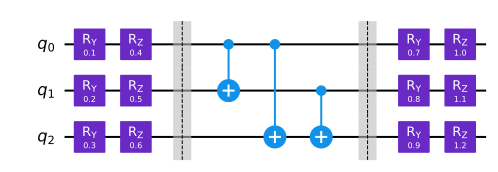

In [5]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
encode = circuit.bind_parameters(x)
encode.decompose().draw()

The Qiskit [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) circuit with 3 qubits, only encodes a data point of 3 features, despite having 6 parameterized gates:

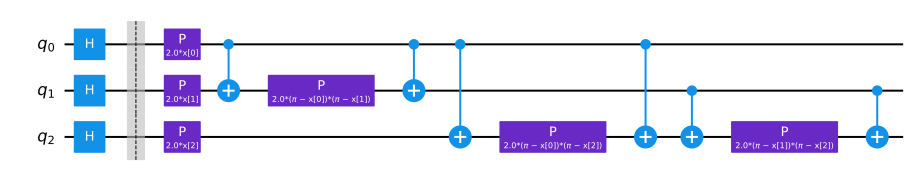

In [6]:
from qiskit.circuit.library import ZZFeatureMap
circuit = ZZFeatureMap(3, reps=1, insert_barriers=True)
circuit.decompose().draw()

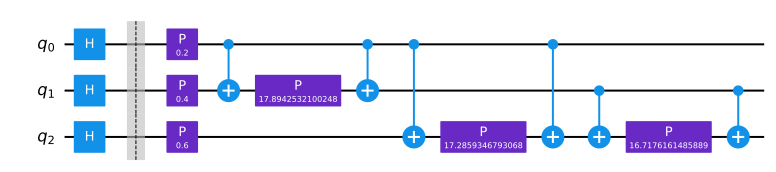

In [7]:
x = [0.1, 0.2, 0.3]
encode = circuit.bind_parameters(x)
encode.decompose().draw()

<!-- ::: q-block.exercise -->

### Quick quiz

<!-- ::: q-quiz(goal="qml-encoding-0") -->

<!-- ::: .question -->

A parameterized quantum circuit has 16 parameters. What is the largest number of features it can encode?

<!-- ::: -->

<!-- ::: .option -->

1. 4

<!-- ::: -->

<!-- ::: .option -->

2. 8

<!-- ::: -->

<!-- ::: .option(correct) -->

3. 16

<!-- ::: -->

<!-- ::: .option -->

3. 32

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

The performance of different parameterized quantum circuits on different types of data is an active area of investigation.

<div style="display: none">

$$\cssId{big-o-times}{\bigotimes}$$

</div>

## References

1.  Maria Schuld and Francesco Petruccione, *Supervised Learning with Quantum Computers*, Springer 2018, [doi:10.1007/978-3-319-96424-9](https://www.springer.com/gp/book/9783319964232).
2. Ryan LaRose and Brian Coyle, *Robust data encodings for quantum classifiers*, Physical Review A 102, 032420 (2020), [doi:10.1103/PhysRevA.102.032420](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.032420), [arXiv:2003.01695](https://arxiv.org/abs/2003.01695).

In [8]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table